## Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

run with cond_tensorflow_p36

In [101]:
# Install required libs
!rm -rf build
!rm -rf dist
!rm -rf segmentation_models
!rm -rf segmentation_models.*

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!git clone https://github.com/qubvel/segmentation_models.git qubvel
!mv qubvel/segmentation_models .
!rm -rf qubvel

You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: segmentation-models in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/segmentation_models-1.0.1-py3.6.egg (1.0.1)
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'qubvel'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 913 (delta 8), reused 4 (delta 0), pack-reused 886
Receiving objects: 100% (913/913), 1.82 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (507/507), done.


In [102]:
!python ./tf_sm_setup.py install

running install
running bdist_egg
running egg_info
creating segmentation_models.egg-info
writing segmentation_models.egg-info/PKG-INFO
writing dependency_links to segmentation_models.egg-info/dependency_links.txt
writing requirements to segmentation_models.egg-info/requires.txt
writing top-level names to segmentation_models.egg-info/top_level.txt
writing manifest file 'segmentation_models.egg-info/SOURCES.txt'
reading manifest file 'segmentation_models.egg-info/SOURCES.txt'
writing manifest file 'segmentation_models.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/dependency_links.txt -> build/b

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 360 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
DATA_DIR = './data/sagemaker/'

In [3]:
!rm -rf {DATA_DIR}/tf_*
#data_bucket = 'kjp-sagemaker-dev'
#!aws s3 cp --quiet --recursive s3://{data_bucket}/floorplans_cubicasa5k/ {DATA_DIR}


In [4]:
import glob, os
import imageio
import PIL
import numpy as np

def process_files(files, target_dir,mask=False):
    for f in files:
        img = PIL.Image.open(f).convert("L")
        img = img.resize((480,360), resample=0)
        npimg = np.array(img)
        new_fname = os.path.basename(f).split('.')[0]
        new_fname = new_fname + ".png" 
        imageio.imsave(os.path.join(target_dir, new_fname), npimg.astype(np.uint8))
    return

images = glob.glob(os.path.join(DATA_DIR,'images','*.jpg'))
os.makedirs(DATA_DIR+'/tf_images', exist_ok=True)
process_files(images, os.path.join(DATA_DIR,'tf_images')) 


In [5]:
os.makedirs(DATA_DIR+'/tf_masks', exist_ok=True)
masks = glob.glob(os.path.join(DATA_DIR,'masks','*.png'))
process_files(masks, os.path.join(DATA_DIR,'tf_masks')) 

In [6]:
import glob, os
os.chdir(DATA_DIR)
allfiles = glob.glob("tf_images/*.png")
num_files = len(allfiles)
trainratio = 0.80
num_train = num_files * 0.80
num_test = num_files * 0.90
i = 0
train=[]
test=[]
validation=[]
for file in allfiles:
    if(i<num_train):
        train.append(file)
    elif(i<num_test):
        test.append(file)
    else:
        validation.append(file)
    i = i + 1
with open('tf_train.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)
with open('tf_test.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)
with open('tf_validation.txt', 'w') as f:
    for item in validation:
        f.write("%s\n" % item)
os.chdir("../..")

In [7]:
!pwd


/home/ec2-user/SageMaker/sagemaker-floorplans


In [8]:
import os
import shutil
from PIL import Image
PREFIX = DATA_DIR + "tf_data/"
os.makedirs(DATA_DIR+'tf_data', exist_ok=True)

print(PREFIX)
# Create directory structure mimicing the s3 bucket where data is to be dumped.
os.makedirs(PREFIX+'/train', exist_ok=True)
os.makedirs(PREFIX+'/validation', exist_ok=True)
os.makedirs(PREFIX+'/train_annotation', exist_ok=True)
os.makedirs(PREFIX+'/validation_annotation', exist_ok=True)
os.makedirs(PREFIX+'/test_annotation', exist_ok=True)
os.makedirs(PREFIX+'/test', exist_ok=True)

# Create a list of all training images.
filename = DATA_DIR+'tf_train.txt'
with open(filename) as f:
    train_list = f.read().splitlines() 

# Create a list of all validation images.
filename = DATA_DIR+'tf_validation.txt'
with open(filename) as f:
    val_list = f.read().splitlines() 
    
# Create a list of all validation images.
filename = DATA_DIR+'tf_test.txt'
with open(filename) as f:
    test_list = f.read().splitlines() 

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping training image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX +'/train/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/train_annotation/'+i.replace('tf_images', '') )

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in test_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping test image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX +'/test/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/test_annotation/'+i.replace('tf_images', ''))


# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping validation image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX+'/validation/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/validation_annotation/'+i.replace('tf_images', ''))

./data/sagemaker/tf_data/


In [9]:
x_train_dir = os.path.join(PREFIX, 'train')
y_train_dir = os.path.join(PREFIX, 'train_annotation')

x_valid_dir = os.path.join(PREFIX, 'validation')
y_valid_dir = os.path.join(PREFIX, 'validation_annotation')

x_test_dir = os.path.join(PREFIX, 'test')
y_test_dir = os.path.join(PREFIX, 'test_annotation')

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['floorplan', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

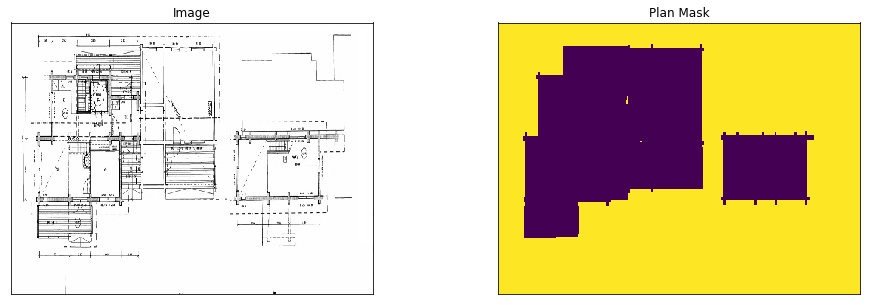

In [11]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['floorplan'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    plan_mask=mask[..., 0].squeeze()
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [12]:
!pip install --upgrade scikit-image
!pip install albumentations==0.4.5

Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.16.2)
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import albumentations as A

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

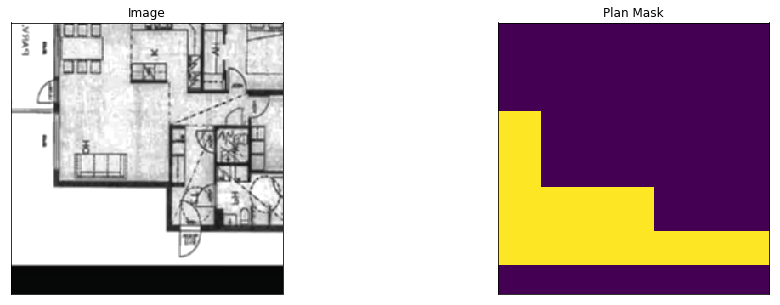

In [15]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['floorplan'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    plan_mask=mask[..., 0].squeeze()
)

# Segmentation model training

In [16]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [17]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['floorplan']
LR = 0.0001
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
print(n_classes)
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

1











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ResourceExhaustedError: OOM when allocating tensor with shape[576] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block5a_bn/moving_variance/biased/Assign (defined at /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'block5a_bn/moving_variance/biased/Assign':
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-aeae4b995ee1>", line 6, in <module>
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
  File "/home/ec2-user/SageMaker/sagemaker-floorplans/segmentation_models/__init__.py", line 34, in wrapper
    return func(*args, **kwargs)
  File "/home/ec2-user/SageMaker/sagemaker-floorplans/segmentation_models/models/unet.py", line 226, in Unet
    **kwargs,
  File "/home/ec2-user/SageMaker/sagemaker-floorplans/segmentation_models/backbones/backbones_factory.py", line 103, in get_backbone
    model = model_fn(*args, **kwargs)
  File "/home/ec2-user/.local/lib/python3.6/site-packages/classification_models/models_factory.py", line 78, in wrapper
    return func(*args, **new_kwargs)
  File "/home/ec2-user/.local/lib/python3.6/site-packages/efficientnet/model.py", line 538, in EfficientNetB3
    **kwargs)
  File "/home/ec2-user/.local/lib/python3.6/site-packages/efficientnet/model.py", line 411, in EfficientNet
    prefix='block{}a_'.format(idx + 1))
  File "/home/ec2-user/.local/lib/python3.6/site-packages/efficientnet/model.py", line 234, in mb_conv_block
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/normalization.py", line 200, in call
    self.momentum)],
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1014, in moving_average_update
    x, value, momentum, zero_debias=True)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/training/moving_averages.py", line 107, in assign_moving_average
    return replica_context.merge_call(merge_fn, args=(variable, value))
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/distribute/distribute_lib.py", line 1940, in merge_call
    return self._merge_call(merge_fn, args, kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/distribute/distribute_lib.py", line 1947, in _merge_call
    return merge_fn(self._strategy, *args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/training/moving_averages.py", line 105, in merge_fn
    return update(strategy, v, value)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/training/moving_averages.py", line 94, in update
    return _zero_debias(strategy, v, value, decay)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/training/moving_averages.py", line 237, in _zero_debias
    trainable=False)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 1500, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 1243, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 567, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 519, in _true_getter
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 933, in _get_single_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 258, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 219, in _variable_v1_call
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 197, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variable_scope.py", line 2519, in default_variable_creator
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 1688, in __init__
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/variables.py", line 1862, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/state_ops.py", line 227, in assign
    validate_shape=validate_shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_state_ops.py", line 66, in assign
    use_locking=use_locking, name=name)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualization of results on test dataset

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )